In [34]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev
import seaborn as sns

In [35]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [36]:

def stats_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics, filter_na = True):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT or DeepJDOT
    """
    metric_stats = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")

        score_df = pd.read_csv(score_path, header=0, index_col=None)

        # get target metric
        metric_stats.append(get_target_stats(score_df, eval_metric, trans_metric, filter_na))

    return metric_stats

In [37]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [38]:
score_dir = f"/home/{user_id}/OTTEHR/outputs/mimic/"

eval_metric = 'MAE'
# eval_metric = 'RMSE'

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

trans_metrics = ['OT', 'TCA', 'CA', 'GFK']



medians for each method is: [ 0.22708073  0.0039536  -0.0501554  -0.27783217]
          OT       TCA        CA       GFK
0   0.287834  0.002156  0.095711 -0.277851
1   0.258072  0.003481  0.172648 -0.278278
2   0.250473  0.001576 -0.076088 -0.333400
3   0.146544  0.001928  0.047842 -0.185244
4   0.272418  0.013726 -0.054357 -0.419046
..       ...       ...       ...       ...
95  0.168091  0.001222 -0.098890 -0.233859
96  0.351882 -0.003564  0.051106 -0.442207
97  0.005795 -0.002322 -0.091174 -0.132222
98  0.254657  0.007351 -0.022678 -0.267328
99  0.245954  0.009037  0.012539 -0.243131

[100 rows x 4 columns]


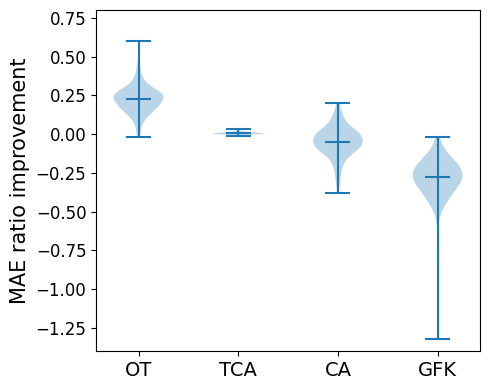

In [39]:
# Overall, for all groups
improve_ratio_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        improve_ratio_combined.extend(improve_ratios)

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = improve_ratio_combined[i]
# print(np.median(trans_metric_dict['GWOT']))
data = pd.DataFrame(trans_metric_dict)
print("medians for each method is:", np.median(data, axis=0))
print(data)


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"{eval_metric} ratio improvement", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels( labels=trans_metrics, fontsize=14)
plt.ylim(-1.4, 0.8)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_ratio.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [40]:
def print_latex(source, target, ratios, percent):
    """ 
    Print latex for ratios
    """

    print_str = f"{source.title()} & {target.title()}"
    for ratio in ratios:
        if percent:
            print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
        else: 
            base = 10**5
            print_str += f' & {median(ratio)/base:.1f}({stdev(ratio)/base:.1f})'
    print_str += ' \\\ \hline'
    print(print_str)
    

In [41]:
for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        # print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        # print(rmse_improve_ratios)
        # print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(group_1, group_2, improve_ratios, percent=True)

Divorced & Separated & 32.2(10.1) & 0.9(1.1) & -5.3(11.4) & -46.7(16.4) \\ \hline
Married & Separated & 32.3(10.0) & 0.4(1.1) & -4.8(11.5) & -45.7(17.7) \\ \hline
Married & Divorced & 25.0(12.1) & 0.5(0.9) & -6.9(12.3) & -29.7(24.9) \\ \hline
Widowed & Separated & 37.4(10.4) & 0.6(0.9) & -0.6(10.8) & -61.5(20.2) \\ \hline
Widowed & Divorced & 30.5(11.9) & 0.5(0.9) & -2.8(11.6) & -40.0(27.6) \\ \hline
Widowed & Married & 32.5(8.5) & 0.6(1.1) & -3.4(10.8) & -42.7(17.7) \\ \hline
Single & Separated & 28.9(9.8) & 0.6(0.9) & -4.7(11.2) & -40.9(17.1) \\ \hline
Single & Divorced & 20.3(11.9) & 0.6(1.3) & -2.3(10.4) & -26.8(23.7) \\ \hline
Single & Married & 22.9(9.5) & 0.4(1.0) & -4.1(10.4) & -30.1(15.1) \\ \hline
Single & Widowed & 19.1(9.1) & 0.4(1.0) & -3.7(9.2) & -23.0(17.6) \\ \hline


trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
trans_metric is: OT
trans_metric is: deepJDOT
median is: 6.172771332269722, 6.289915


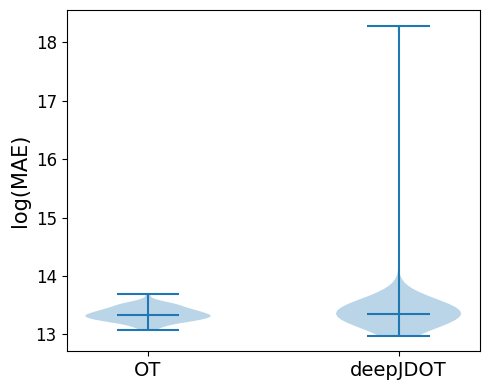

In [46]:
# Present the overall performance for deepJDOT and OTTEHR
trans_metrics = ['OT', 'deepJDOT']
stats_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)
        stats_combined.extend(stats)

# fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_deepJDOT.pdf")

# plt.tight_layout()
# plt.savefig(fig_path, bbox_inches='tight')
# plt.show()

base = 10**5
print(f"median is: {median(stats_combined[0])/base}, {median(stats_combined[1])/base}")

# Apply log to stats_combined
for i in range(len(stats_combined)):
    stats_combined[i] = [np.log(x) for x in stats_combined[i]]


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot([stats_combined[0], stats_combined[1]], showmedians=True)
# plt.violinplot([stats_combined[0], stats_combined[1], stats_combined[2], stats_combined[3], stats_combined[4]], showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metrics, fontsize=14)
# plt.ylim(12, 22)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_deepJDOT.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [47]:
# Calculate the pairwise performance for deepJDOT and OTTEHR


for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)

        print_latex(group_1, group_2, stats, percent=False)

trans_metric is: OT
trans_metric is: deepJDOT
Divorced & Separated & 6.0(0.8) & 6.0(0.8) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Married & Separated & 6.0(0.8) & 6.0(14.2) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Married & Divorced & 5.8(0.7) & 5.6(6.4) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Widowed & Separated & 5.5(0.7) & 5.4(0.6) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Widowed & Divorced & 5.3(0.8) & 5.1(4718.4) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Widowed & Married & 5.1(0.5) & 5.0(4431.7) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Single & Separated & 6.3(0.8) & 6.5(0.8) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Single & Divorced & 6.3(0.9) & 6.2(4183.7) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Single & Married & 6.2(1.1) & 6.4(2025.7) \\ \hline
trans_metric is: OT
trans_metric is: deepJDOT
Single & Widowed & 5.9(0.7) & 6.0(2888.2) \\ \hline


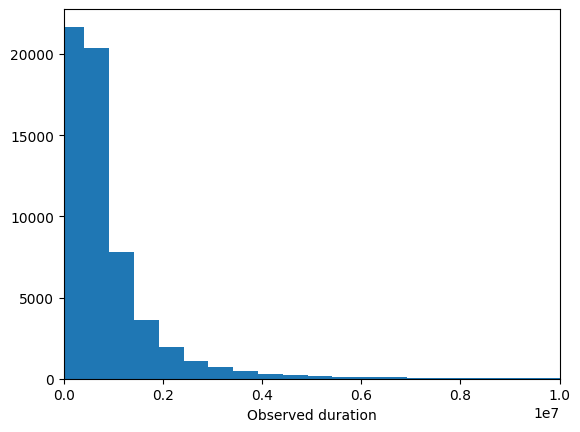

In [44]:
# Plot the distribution of the observed duration in hospital
admid_diagnosis_df = pd.read_csv(os.path.join(mimic_output_dir, "ADMID_DIAGNOSIS.csv"), index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df['duration']
durations = list(admid_diagnosis_df['duration'])
binwidth = 0.05*10**7
plt.hist(durations, bins=np.arange(min(durations), max(durations) + binwidth, binwidth))
plt.xlim(0, 10**7)
plt.xlabel('Observed duration')
plt.savefig(os.path.join(mimic_output_dir, "observed_duration_distn.pdf"))


In [45]:
# Analyze the precision and recall of the task 
# From the previous plot, we use 1e6 as the threshold 